In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import glob
import random
import skopt

ModuleNotFoundError: No module named 'skopt'

In [15]:
def read_csv( filename ):
    if isinstance(filename, pd.DataFrame): return filename  
    
    dataframe = pd.read_csv( filename )
    
    dataframe['Date'] = pd.to_datetime(dataframe.Date)
    return dataframe

def meanDailyReturn( filename ):
    return read_csv( filename )['Close Price'].pct_change().dropna().mean()

def meanDailySTD( filename ):
    return read_csv( filename )['Close Price'].pct_change().dropna().std()

def meanAnnualReturn( filename ):
    return meanDailyReturn(filename) * 252

def meanAnnualSTD( filename ):
    return meanDailySTD(filename) * np.sqrt(252)

def getName( filename ):
    return re.sub(r'^.+/|\.[^.]+$',     '',    filename)

def getCap( filename ):
    return re.sub(r'^.*/(\w+_Cap)/.*$', '\\1', filename)

def calcReturnVolatility( filename ):
    input  = read_csv( filename )
    output = DataFrame([{
        "Name":             getName( filename ),
        "Cap":              getCap(  filename ),
        "meanDailyReturn":  meanDailyReturn( input ),
        "meanDailySTD":     meanDailySTD( input ),
        "meanAnnualReturn": meanAnnualReturn( input ),
        "meanAnnualSTD":    meanAnnualSTD( input )
    }])
    output.set_index( output.Name, inplace=True, drop=False )
    return output

stock = r'E:/Internship/Large_Cap/Large_Cap/ADANIPORTS.csv'
calcReturnVolatility(stock)


,Name,Cap,meanDailyReturn,meanDailySTD,meanAnnualReturn,meanAnnualSTD
Name,,,,,,
ADANIPORTS,ADANIPORTS,Large_Cap,0.00024,0.019493,0.060376,0.309436


In [19]:
filenames_all = glob.glob(r'E:/Internship/Large_Cap/Large_Cap/*.csv')
filenames     = random.sample( filenames_all, 5 )

summary_all   = pd.concat([ calcReturnVolatility(stock) for stock in filenames_all ])
summary       = pd.concat([ calcReturnVolatility(stock) for stock in filenames     ])
summary

,Name,Cap,meanDailyReturn,meanDailySTD,meanAnnualReturn,meanAnnualSTD
Name,,,,,,
Large_Cap\ADANIPORTS,Large_Cap\ADANIPORTS,Large_Cap,0.000240,0.019493,0.060376,0.309436
Large_Cap\HDFCBANK,Large_Cap\HDFCBANK,Large_Cap,0.000751,0.015151,0.189263,0.240513
Large_Cap\CIPLA,Large_Cap\CIPLA,Large_Cap,0.000047,0.015997,0.011769,0.253941
Large_Cap\ASIANPAINT,Large_Cap\ASIANPAINT,Large_Cap,0.000388,0.013181,0.097791,0.209249
Large_Cap\BPCL,Large_Cap\BPCL,Large_Cap,-0.001035,0.027464,-0.260891,0.435982


In [22]:
portfolio = DataFrame()
for filename in filenames:
    portfolio[ getName(filename) ] = read_csv(filename)['Close Price']
portfolio.head()

,Large_Cap\ADANIPORTS,Large_Cap\HDFCBANK,Large_Cap\CIPLA,Large_Cap\ASIANPAINT,Large_Cap\BPCL
0,356.20,1553.40,569.00,1148.05,727.85
1,354.50,1583.00,565.60,1142.85,733.30
2,348.55,1559.65,562.35,1154.95,727.45
3,347.90,1557.15,560.10,1151.35,714.90
4,349.45,1600.00,564.95,1123.15,702.45


In [23]:

equal_weights = np.full( portfolio.shape[1], 1/portfolio.shape[1] )
equal_weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [24]:
def portfolio_annual_returns(portfolio, weights):
    return np.sum( portfolio.pct_change().mean() * weights ) * 252  

round( portfolio_annual_returns(portfolio, equal_weights), 2 )

0.02

In [25]:
portfolio_covarence = portfolio.pct_change().cov()
portfolio_covarence

,Large_Cap\ADANIPORTS,Large_Cap\HDFCBANK,Large_Cap\CIPLA,Large_Cap\ASIANPAINT,Large_Cap\BPCL
Large_Cap\ADANIPORTS,0.000380,-0.000034,0.000070,0.000051,0.000097
Large_Cap\HDFCBANK,-0.000034,0.000261,-0.000012,0.000007,-0.000005
Large_Cap\CIPLA,0.000070,-0.000012,0.000256,0.000027,0.000029
Large_Cap\ASIANPAINT,0.000051,0.000007,0.000027,0.000174,0.000100
Large_Cap\BPCL,0.000097,-0.000005,0.000029,0.000100,0.000754


In [26]:
def portfolio_annual_volatility( portfolio, weights ): 
    return np.sqrt(
        np.dot( 
            weights.T, 
            np.dot( portfolio.pct_change().cov(), weights )
        ) 
        * np.sqrt(252)
    )

round( portfolio_annual_volatility(portfolio, equal_weights), 2 )

0.04

In [27]:
def portfolio_sharpe( portfolio, weights ): 
    return portfolio_annual_returns( portfolio, weights ) / portfolio_annual_volatility( portfolio, weights )

round( portfolio_sharpe(portfolio, equal_weights), 2 )

0.4

In [28]:

print("Portfolio Annualized Mean Return: ", round( portfolio_annual_returns(    portfolio, equal_weights ), 2) )
print("Portfolio Annualized Volatility:  ", round( portfolio_annual_volatility( portfolio, equal_weights ), 2) )

Portfolio Annualized Mean Return:  0.02
Portfolio Annualized Volatility:   0.04


In [29]:
def normalize_weights( weights ):
    for i in range(0,3):
        weights  = np.round( weights, 3 ) 
        weights /= weights.sum()
    return np.asarray(weights)
    
def random_weights():
    weights  = np.random.rand(portfolio.shape[1])
    return normalize_weights( weights )

random_weights()

array([0.313, 0.367, 0.01 , 0.113, 0.197])

In [30]:

scatter_data = DataFrame()
for i in range(0, 2500):
    weights    = random_weights()
    returns    = portfolio_annual_returns(    portfolio, weights )
    volatility = portfolio_annual_volatility( portfolio, weights )
    sharpe     = returns / volatility
    scatter_data = scatter_data.append([{
        "weights":    weights,
        "returns":    returns,
        "volatility": volatility,
        "sharpe":     sharpe
    }])

scatter_data.reset_index(inplace=True, drop=True)
scatter_data.head()

,weights,returns,volatility,sharpe
0,"[0.2852852852852853, 0.1701701701701702, 0.225...",0.018952,0.040897,0.463402
1,"[0.23423423423423426, 0.21921921921921922, 0.0...",-0.030649,0.051464,-0.595538
2,"[0.379, 0.135, 0.066, 0.237, 0.183]",0.021661,0.045150,0.479750
3,"[0.278, 0.196, 0.279, 0.174, 0.073]",0.052297,0.037803,1.383400
4,"[0.027, 0.267, 0.259, 0.163, 0.284]",-0.007793,0.043255,-0.180165


In [31]:
point_max_sharpe     = scatter_data.loc[ scatter_data['sharpe'].idxmax()     ]
point_max_sharpe

weights       [0.108, 0.525, 0.019, 0.346, 0.002]
returns                                  0.125886
volatility                              0.0399347
sharpe                                    3.15229
Name: 654, dtype: object

In [33]:

point_min_volatility = scatter_data.loc[ scatter_data['volatility'].idxmin() ]
point_min_volatility

weights       [0.159, 0.264, 0.25, 0.296, 0.031]
returns                                0.0785193
volatility                             0.0342713
sharpe                                   2.29111
Name: 1937, dtype: object

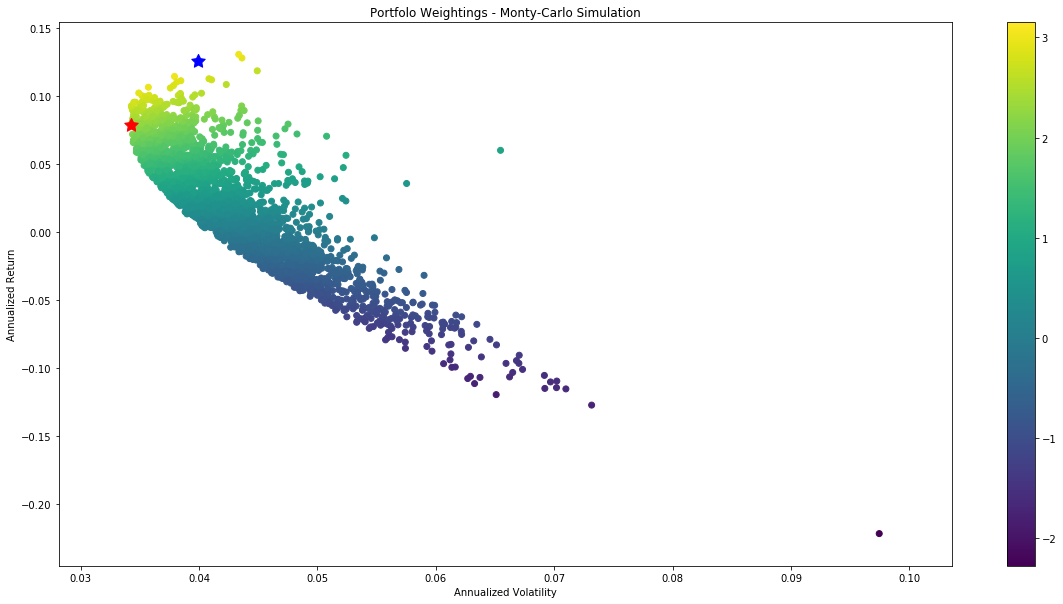

In [34]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
plt.scatter( 
    scatter_data.volatility,     
    scatter_data.returns, 
    c = scatter_data.sharpe
)
plt.title('Portfolo Weightings - Monty-Carlo Simulation')
plt.ylabel('Annualized Return')
plt.xlabel('Annualized Volatility')
plt.colorbar()

# Mark the 2 portfolios where
plt.scatter( point_max_sharpe.volatility,     point_max_sharpe.returns,     marker=(5,1,0), c='b', s=200 )
plt.scatter( point_min_volatility.volatility, point_min_volatility.returns, marker=(5,1,0), c='r', s=200 )

In [ ]:
def max_sharpe( weights ):
    weights = normalize_weights(weights)
    sharpe  = portfolio_annual_returns( portfolio, weights ) / portfolio_annual_volatility( portfolio, weights )
    return  -sharpe  # convert maximization for minimization

skopt_max_sharpe = skopt.gp_minimize(
    max_sharpe, 
    [(0., 1.),(0., 1.),(0., 1.),(0., 1.),(0., 1.)],  # must be floating point array
    verbose=False,
    n_calls=30,         # the number of evaluations of f 
    n_random_starts=5,  # the number of random initialization points
    random_state=123    # the random seed    
)
print( "Max Sharpe Ratio Value   - skopt:       ", -skopt_max_sharpe.fun )
print( "Max Sharpe Ratio Value   - Monty Carlo: ",  point_max_sharpe.sharpe  )
print( "Max Sharpe Ratio Improvement:           ",  round( abs(-skopt_max_sharpe.fun / point_max_sharpe.sharpe), 2), 'x'  )
print( "Max Sharpe Ratio Weights - skopt:       ",  skopt_max_sharpe.x )
print( "Max Sharpe Ratio Weights - Monty Carlo: ",  point_max_sharpe.weights  )

In [ ]:
def min_volatility( weights ):
    weights    = normalize_weights(weights)
    volatility = portfolio_annual_volatility( portfolio, weights )
    return volatility
    
# DOCS: https://scikit-optimize.github.io/#skopt.gp_minimize
skopt_min_volatility = skopt.gp_minimize(
    min_volatility, 
    [(0., 1.),(0., 1.),(0., 1.),(0., 1.),(0., 1.)],  # must be floating point array
    verbose=False,
    n_calls=30,         # the number of evaluations of f 
    n_random_starts=5,  # the number of random initialization points
    random_state=123    # the random seed        
)
print( "Min Volatility Value   - skopt:       ",  skopt_min_volatility.fun )
print( "Min Volatility Value   - Monty Carlo: ",  point_min_volatility.volatility  )
print( "Min Volatility Weights - skopt:       ",  skopt_min_volatility.x )
print( "Min Volatility Weights - Monty Carlo: ",  point_min_volatility.weights  )

NameError: name 'skopt_max_sharpe' is not defined

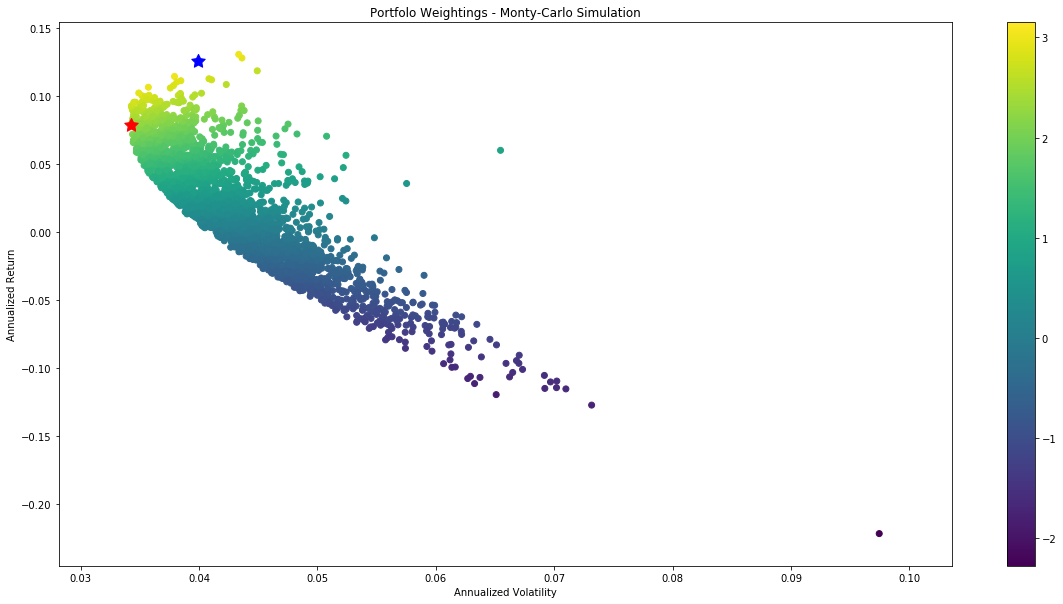

In [38]:

fig, ax = plt.subplots(figsize=(20, 10), nrows=1, ncols=1)
plt.scatter( 
    scatter_data.volatility,     
    scatter_data.returns, 
    c = scatter_data.sharpe
)
plt.title('Portfolo Weightings - Monty-Carlo Simulation')
plt.ylabel('Annualized Return')
plt.xlabel('Annualized Volatility')
plt.colorbar()

# Mark the 2 portfolios where
plt.scatter( point_max_sharpe.volatility,     point_max_sharpe.returns,     marker=(5,1,0), c='b', s=200 )
plt.scatter( point_min_volatility.volatility, point_min_volatility.returns, marker=(5,1,0), c='r', s=200 )
plt.scatter( 
    portfolio_annual_volatility( portfolio, normalize_weights(skopt_max_sharpe.x) ),     
    portfolio_annual_returns(    portfolio, normalize_weights(skopt_max_sharpe.x) ), 
    marker=(4,2,0), c='b', s=200 
)
plt.scatter( 
    portfolio_annual_volatility( portfolio, normalize_weights(skopt_min_volatility.x) ),     
    portfolio_annual_returns(    portfolio, normalize_weights(skopt_min_volatility.x) ), 
    marker=(4,2,0), c='r', s=200 
)

In [ ]:
summary_all['Sharpe'] = summary_all.meanAnnualReturn / summary_all.meanAnnualSTD

fig, axes = plt.subplots(figsize=(20, 30), nrows=2, ncols=1)
for n in range(0,2):
    axes[n].scatter( 
        summary_all.meanAnnualReturn, 
        summary_all.meanAnnualSTD, 
        c     = summary_all['Sharpe'],
        label = summary_all['Sharpe']
    )
    axes[n].set_title('Returns vs Volatility')
    axes[n].set_xlabel('Annualized Return')
    axes[n].set_ylabel('Annualized Volatility')

for i in range(0, summary_all.shape[0]):
    axes[n].annotate(summary_all.Name[i], (summary_all.meanAnnualReturn[i]+0.02, summary_all.meanAnnualSTD[i] - 0.005))

In [40]:

portfolio_1 = summary_all.sort_values('Sharpe',ascending=False).head(5)
portfolio_1

,Name,Cap,meanDailyReturn,meanDailySTD,meanAnnualReturn,meanAnnualSTD,Sharpe
Name,,,,,,,
Large_Cap\HDFC,Large_Cap\HDFC,Large_Cap,1.387116,2.439083,349.553272,38.719236,9.027897
Large_Cap\HINDUNILVR,Large_Cap\HINDUNILVR,Large_Cap,0.001186,0.012211,0.298772,0.193846,1.541285
Large_Cap\TITAN,Large_Cap\TITAN,Large_Cap,0.001943,0.020422,0.489609,0.324192,1.510246
Large_Cap\BAJFINANCE,Large_Cap\BAJFINANCE,Large_Cap,0.001799,0.020204,0.453413,0.320735,1.413666
Large_Cap\AXISBANK,Large_Cap\AXISBANK,Large_Cap,0.000924,0.017489,0.232722,0.277636,0.838228


In [41]:
portfolio_2 = summary_all.sort_values('meanAnnualSTD',ascending=True).head(5)
portfolio_2

,Name,Cap,meanDailyReturn,meanDailySTD,meanAnnualReturn,meanAnnualSTD,Sharpe
Name,,,,,,,
Large_Cap\HINDUNILVR,Large_Cap\HINDUNILVR,Large_Cap,0.001186,0.012211,0.298772,0.193846,1.541285
Large_Cap\ASIANPAINT,Large_Cap\ASIANPAINT,Large_Cap,0.000388,0.013181,0.097791,0.209249,0.467343
Large_Cap\ITC,Large_Cap\ITC,Large_Cap,0.000182,0.014136,0.045743,0.224401,0.203843
Large_Cap\MARUTI,Large_Cap\MARUTI,Large_Cap,0.000016,0.014174,0.003921,0.225002,0.017426
Large_Cap\HEROMOTOCO,Large_Cap\HEROMOTOCO,Large_Cap,-0.000570,0.015064,-0.143545,0.239141,-0.600251
